In [1]:
# Standard libraries
from itertools import chain

# Parallelization library
from joblib import Parallel, delayed

# Scientific libraries
import pandas as pd
from numpy import array, arange, nan
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets

# Utility functions
from helpers.helpers_pandas import jenks_filter

Load the data

In [2]:
# Load the data
tracks_df = pd.read_pickle('../Data/pkl/01_spotify_data_(notna).pkl')
genre_info_df = pd.read_pickle('../Data/pkl/02_everynoise_data.pkl')[['genre', 'sim_genres', 'sim_weights', 'x', 'y', 'color']]

# Genres community detection

3 strategies are possible:
- Option 1: Use the "edges" naturally contained in our spotify Data (i.e. when one song "belongs" to 2 genres, those 2 genres are connected) 
- Option 2: Use the edges from EveryNoise website (i.e. if a genre si similar to another one, they share an edges)
- Option 3: Use a mix of both

I'm going for option 2 (the option 3 adds the challenge to justify the "combination" of each (average? Weighted average?)

In [3]:
# list all genres associated with a track
df_track_genres = tracks_df[['spotify_id', 'genres']].explode('genres')
df_track_genres

,spotify_id,genres
0,1gr3wnx384k5kcQAs2S1FA,classical harp
1,4qzIWW9yArNdpuqc9SbtJH,progressive house
2,1y9KCKHJq5Wy8JTOUKy5O1,hip-hop experimental
3,3uI33EsE7AVM3GMxaOn7fv,ethnotronica
3,3uI33EsE7AVM3GMxaOn7fv,organic electronic
...,...,...
2158,6Vhtb9RU1thtzBcsy3bI9q,kirtan
2158,6Vhtb9RU1thtzBcsy3bI9q,world fusion
2159,03FcCV2h88qkjuhTaEB5Zh,high vibe
2159,03FcCV2h88qkjuhTaEB5Zh,kirtan


In [4]:
# list all tracks associated with each genre
df_tracks_per_genre = tracks_df[['spotify_id', 'genres']].explode('genres').groupby('genres').agg(list)
df_tracks_per_genre

,spotify_id
genres,
21st century classical,[0gByie4ptADcvfEEdFAFjB]
abstract,[03xyBEUCBBWZejQvDPXE94]
abstract beats,"[59xPgtPmhM16y47JX3ETUO, 2MYPFXScWdR3PQihBQxu7x]"
abstract hip hop,"[0odEKJ2vPJFEJnwJiGAXz1, 2pXTXagaryzNBfkyNyzuq..."
abstract idm,[3wAGMTVMUdhEx22mLdJZNf]
...,...
zenonesque,[6vBhadlx5nakGCwDENfCPw]
zilizopendwa,"[17bKimjkfYmDvHU2getgpZ, 4pMpXLVmlSbIjhZ552S2S..."
zim urban groove,"[4pMpXLVmlSbIjhZ552S2Sl, 0EB6LdcMyj0SHhCAR45CRi]"


To Use option 3, we can use this code snippet

In [5]:
# # Get the edges list contained in our Spotify Data
# # 2 tracks are connected if they share a same genre
# # the more common genres 2 tracks share, the more the weight

# sp_source = df_track_genres['spotify_id'].rename('source')
# sp_target = df_track_genres['genres'].map(df_tracks_per_genre['spotify_id']).rename('target')
# sp_edges = pd.concat([sp_source, sp_target], axis=1).explode('target').reset_index(drop=True)
# sp_edges['weight'] = 1 
# sp_edges

## Get edges list contained in ENAO data

In [6]:
# Normalize weight of ENAO data
# edge weight is divided by the sum of the edges'weight of the source node
genre_info_df['norm_weights'] = (genre_info_df['sim_weights'].apply(array)) / (genre_info_df['sim_weights'].apply(sum))
genre_info_df.drop(columns=['sim_weights'], inplace=True)
genre_info_df

,genre,sim_genres,x,y,color,norm_weights
0,musica andina,"[folklore cuyano, banjo, french movie tunes, r...",926.0,7000.0,"[0.47058823529411764, 0.5803921568627451, 0.21...","[0.040032025620496396, 0.040032025620496396, 0..."
1,psybass,"[uk bass, glitch hop, deep progressive trance,...",1011.0,18296.0,"[0.7098039215686275, 0.5411764705882353, 0.533...","[0.04455227172474636, 0.0458756065284517, 0.04..."
2,cologne electronic,"[somatik techno, bleep techno, experimental ho...",1098.0,18697.0,"[0.5882352941176471, 0.5764705882352941, 0.745...","[0.046500920810313075, 0.046500920810313075, 0..."
3,miami hip hop,"[hindi hip hop, dirty south rap, australian hi...",1067.0,17076.0,"[0.6901960784313725, 0.5176470588235295, 0.027...","[0.04936461388074291, 0.05474095796676442, 0.0..."
4,high-tech minimal,"[deep deep house, romanian electronic, israeli...",1357.0,20220.0,"[0.6862745098039216, 0.5686274509803921, 0.784...","[0.04892367906066536, 0.049902152641878667, 0...."
...,...,...,...,...,...,...
968,guinean pop,"[oyun havasi, meyxana, west african jazz, togo...",1013.0,11819.0,"[0.7058823529411765, 0.5333333333333333, 0.050...","[0.03625269203158651, 0.03625269203158651, 0.0..."
969,armenian folk,"[classic nz pop, musica mallorquina, musica ma...",677.0,10270.0,"[0.5882352941176471, 0.5411764705882353, 0.176...","[0.044326241134751775, 0.044326241134751775, 0..."
970,icelandic experimental,"[experimental folk, ambient pop, kundalini, no...",335.0,8008.0,"[0.36470588235294116, 0.5803921568627451, 0.45...","[0.0427061310782241, 0.04397463002114165, 0.04..."
971,swedish electronic,"[eletronica underground brasileira, norwegian ...",1197.0,19703.0,"[0.6941176470588235, 0.5607843137254902, 0.776...","[0.044395604395604395, 0.04395604395604396, 0...."


In [7]:
# Sanity check
mask = genre_info_df.isna().any(axis=1)
genre_info_df[mask]

,genre,sim_genres,x,y,color,norm_weights
231,writing,"[german literature, motivation, reading, barns...",NaN,NaN,NaN,"[0.16230366492146597, 0.13612565445026178, 0.1..."
333,bossbeat,"[solipsynthm, swedish synthpop, aussietronica,...",NaN,NaN,NaN,"[0.04978038067349927, 0.04880429477794046, 0.0..."
438,urbano mexicano,"[trap cristiano, r&b en espanol, seychelles po...",NaN,NaN,NaN,"[0.04728132387706856, 0.052955082742316785, 0...."
453,handpan,"[piano worship, calming instrumental, japanese...",NaN,NaN,NaN,"[0.10703043022035677, 0.1049317943336831, 0.11..."
535,spectra,"[dark jazz, icelandic experimental, chamber ps...",NaN,NaN,NaN,"[0.04777672658467361, 0.04777672658467361, 0.0..."


In [8]:
# Extract edges from ENAO data based on shared genres between tracks
# 2 tracks are connected if they share a similar genre
# the weight depends on how similar the genre the tracks share are

enao_source = df_track_genres['spotify_id'].rename('source')
enao_target = df_track_genres['genres'].map(genre_info_df.set_index(['genre'])['sim_genres']).rename('target')
enao_weight = df_track_genres['genres'].map(genre_info_df.set_index(['genre'])['norm_weights']).rename('weight')

# combine the source (tracks) + similar genres + weight
enao_edges = pd.concat([enao_source, enao_target, enao_weight], axis=1).set_index('source').apply(pd.Series.explode).reset_index()
# replace similar genres with all tracks associated to that genre
enao_edges['target'] = enao_edges['target'].map(df_tracks_per_genre['spotify_id'])
# drop NAN in case some similar genres were not present in our spotify data
enao_edges = enao_edges.dropna().explode('target')
enao_edges

,source,target,weight
5,1gr3wnx384k5kcQAs2S1FA,2Zy9Ob4btKb32RpRtWsk3B,0.192308
6,4qzIWW9yArNdpuqc9SbtJH,6f8gNNCNSveUl4gxt7tzp0,0.036892
6,4qzIWW9yArNdpuqc9SbtJH,4AoQ3IvQqXjFhvtVyrGfGn,0.036892
6,4qzIWW9yArNdpuqc9SbtJH,1OCrb7dmygmJiDcjdFAPR8,0.036892
6,4qzIWW9yArNdpuqc9SbtJH,2nyz22HwEpnoB49L66U3Zt,0.036892
...,...,...,...
210250,03FcCV2h88qkjuhTaEB5Zh,5mkifGygtTsK0LPzS4izQg,0.044203
210250,03FcCV2h88qkjuhTaEB5Zh,5GBajLM2mFo1zL4IPmw8qR,0.044203
210250,03FcCV2h88qkjuhTaEB5Zh,2gEZhXXPAa1PnAz3BouoAi,0.044203
210250,03FcCV2h88qkjuhTaEB5Zh,34w5is3aIx0z3UZQoJHmVz,0.044203


In our case, since we use Option 2

In [9]:
edges = enao_edges
# # sum duplicates edges (only in one direction)
# edges = edges.groupby(['source', 'target']).sum().reset_index()
# # remove loops (nodes connected to themselves)
# edges = edges[edges['source'] != edges['target']]
# # normalize weight (and round to integer)
# edges['weight'] = (edges['weight']/edges['weight'].min()).astype(int)
# # Reorder and reset index
# edges = edges.sort_values('weight', ascending=False).reset_index(drop=True)
edges

,source,target,weight
5,1gr3wnx384k5kcQAs2S1FA,2Zy9Ob4btKb32RpRtWsk3B,0.192308
6,4qzIWW9yArNdpuqc9SbtJH,6f8gNNCNSveUl4gxt7tzp0,0.036892
6,4qzIWW9yArNdpuqc9SbtJH,4AoQ3IvQqXjFhvtVyrGfGn,0.036892
6,4qzIWW9yArNdpuqc9SbtJH,1OCrb7dmygmJiDcjdFAPR8,0.036892
6,4qzIWW9yArNdpuqc9SbtJH,2nyz22HwEpnoB49L66U3Zt,0.036892
...,...,...,...
210250,03FcCV2h88qkjuhTaEB5Zh,5mkifGygtTsK0LPzS4izQg,0.044203
210250,03FcCV2h88qkjuhTaEB5Zh,5GBajLM2mFo1zL4IPmw8qR,0.044203
210250,03FcCV2h88qkjuhTaEB5Zh,2gEZhXXPAa1PnAz3BouoAi,0.044203
210250,03FcCV2h88qkjuhTaEB5Zh,34w5is3aIx0z3UZQoJHmVz,0.044203


If we wanted to use Option 3, we would use the following step

In [10]:
# combine Spotify and ENAO-derived edges
# edges = pd.concat([sp_edges, enao_edges])
# # sum duplicates edges (only in one direction)
# edges = edges.groupby(['source', 'target']).sum().reset_index()
# # remove loops (nodes connected to themselves)
# edges = edges[edges['source'] != edges['target']]
# # normalize weight (and round to integer)
# edges['weight'] = (edges['weight']/edges['weight'].min()).astype(int)
# # Reorder and reset index
# edges = edges.sort_values('weight', ascending=False).reset_index(drop=True)
# edges

In [11]:
# Convert to iGraph
G = ig.Graph.DataFrame(edges, directed=False)
G.simplify(combine_edges='sum')  # both direction

In [12]:
# Convert back the edges list after simplification in DataFrame
# (Not necessary, only by curiosity)
G_edges = G.get_edge_dataframe()
G_nodes = G.get_vertex_dataframe()
G_edges['source'].replace(G_nodes['name'], inplace=True)
G_edges['target'].replace(G_nodes['name'], inplace=True)
# G_edges['weight'] = (G_edges['weight'] / G_edges['weight'].min()).astype(int)
G_edges.sort_values('weight', ascending=False, inplace=True)
G_edges

,source,target,weight
edge ID,,,
103692,0fzHYp3K1F1JKyQJM3Xy21,2p2kH4FCxWy0OSkaIuz7an,9.480938
331332,2p2kH4FCxWy0OSkaIuz7an,66QT68qxiBNyA7b95ur5Bm,7.604963
103753,0fzHYp3K1F1JKyQJM3Xy21,66QT68qxiBNyA7b95ur5Bm,7.604963
185457,1Sp1eXSBaR4thIAXbWbyoA,2p2kH4FCxWy0OSkaIuz7an,7.485500
103664,0fzHYp3K1F1JKyQJM3Xy21,1Sp1eXSBaR4thIAXbWbyoA,7.485500
...,...,...,...
367701,3CZ7sohRSvAKMXBKM9JX8d,5wD4sfANjvUDEzOtFWDyTj,0.017185
75131,0WON7ccM42foBwZikHsf7v,3CZ7sohRSvAKMXBKM9JX8d,0.017185
211811,1iUpKFWs8Uskzc1VXhLdLk,1lz4RkL4oK07X0UAMEbqQT,0.016722


Weights ranges from 0.016722408026755852 to 9.480938342335236


<AxesSubplot:title={'center':'Weight distribution'}>

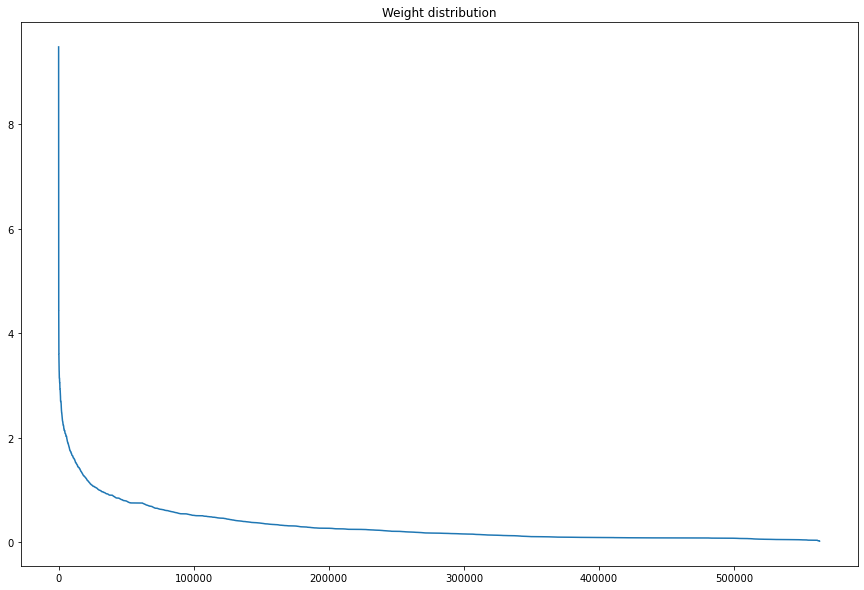

In [13]:
# Display weight distribution
print(f"Weights ranges from {G_edges['weight'].min()} to {G_edges['weight'].max()}")
G_edges['weight'].sort_values(ascending=False
    ).reset_index(drop=True
    ).plot(figsize=(15,10), title='Weight distribution')

## Detect genre communities

In [14]:
def get_partition(graph, weight=None, seed=0):
    """Detect in communities in the graph using Leiden Algorithm.

    Args:
        graph (igraph.Graph): The input graph
        weight (float or None, optional): The weight to be considered during the partition. Defaults to None.
        seed (int, optional): The random seed to use. Defaults to 0.

    Returns:
        Partition: The detected communities in the graph.
    """
    return la.find_partition(
        graph,
        la.ModularityVertexPartition, 
        n_iterations = -1, 
        weights = weight, 
        seed = seed
    )


def calculate_modularity(graph, weight, seed):
    """Calculate modularity of graph partition using given parameters.

    Args:
        graph (igraph.Graph): The input graph.
        weight (str): The edge attribute to use as weights. None for unweighted graph.
        seed (int): The random seed for the Leiden algorithm.

    Returns:
        tuple: A tuple containing the input seed and the modularity of the resulting partition.
    """
    partition = get_partition(graph=graph, weight=weight, seed=seed)
    modularity = partition.modularity
    return (seed, modularity)


def get_genre_communities(graph, weight, seeds=10):
    """Get best communities (based on modularity) out of N tries 

    Args:
        graph (igraph.Graph): The input graph.
        weight (str): The edge attribute to use as weights. None for unweighted graph.
        seeds (int, optional): The number of seeds to try for Leiden algorithm. Defaults to 10.

    Returns:
        dict: A dictionary containing information about the detected communities.
    """
    # Select the best result given the modularity
    results = Parallel(n_jobs=-1)(
        delayed(calculate_modularity)(graph=graph, weight=weight, seed=seed)
        for seed in range(seeds)
    )
    best_seed, best_modularity = max(results, key=lambda item: item[1])

    # Get the partition associated with the best seed
    partition = get_partition(graph=graph, weight=weight, seed=best_seed)
    
    # Extract cluster information
    clusters = dict()
    genre_to_cluster = dict()
    for i, cluster in enumerate(partition):
        # clusters[i] = graph.vs[cluster]["name"]
        # genre_to_cluster.update({genre: i for genre in graph.vs[cluster]["name"]})
        genres = graph.vs[cluster]["name"]
        clusters[i] = genres
        for genre in genres:
            genre_to_cluster[genre] = i

    return {
        "genre_to_cluster": genre_to_cluster,              # keys = genres and values = clusters associated
        "seed": best_seed,       # seed associated with the best partition found
        "clusters": clusters,    # keys = cluster, values = all genres associated
        "modularity": best_modularity,  # modularity for the best partition found
        "size": len(partition),  # number of clusters
        "partition": partition,  # the actual partition
    }

In [15]:
# Run the community detection algorithm
genre_clusters = get_genre_communities(graph=G, weight='weight', seeds=200)
print(f"The partitions includes {genre_clusters['size']} clusters")
print(f"The modularity of the partition found by the Leiden Algorithm is: {genre_clusters['modularity']}")

The partitions includes 8 clusters
The modularity of the partition found by the Leiden Algorithm is: 0.3295542290433545


## Assign each track to its cluster

In [16]:
# Map each song ot its corresponding cluster and sort cluster by popularity
tracks_df['cluster'] = tracks_df['spotify_id'].map(genre_clusters['genre_to_cluster'])
tracks_df = tracks_df.sort_values(['cluster', 'popularity'], axis=0, ascending=[True, False]).reset_index(drop=True)
tracks_df[['title', 'artists', 'genres', 'cluster','popularity']]

,title,artists,genres,cluster,popularity
0,Sail,[AWOLNATION],"[la indie, modern alternative rock, modern roc...",0.0,74
1,Intro,[The xx],"[downtempo, dream pop, indietronica]",0.0,73
2,Teardrop,[Massive Attack],"[big beat, downtempo, electronica, trip hop]",0.0,71
3,Porcelain,[Moby],"[downtempo, electronica]",0.0,70
4,Glory Box,[Portishead],"[dark pop, electronica, laboratorio, trip hop]",0.0,70
...,...,...,...,...,...
2149,The Deepest Dream (Theta Waves),[Naturalis],"[rain, sound]",6.0,31
2150,Calmer (4 Hz Theta Binaural Beat),[Naturalis],"[rain, sound]",6.0,29
2151,Karibu - Radio Edit,[Lago],"[blackened hardcore, neo-crust]",7.0,0
2152,A New Beginning (Theta Drone L216Hz R220Hz),[Bruce Brus],[white noise],NaN,20


In [17]:
# Mind the track that do not belong to any cluster (there were singletons in our spotify data)
mask = tracks_df['cluster'].isna()
tracks_df[mask]

,spotify_id,title,artists,artists_id,genres,popularity,energy,valence,danceability,acousticness,loudness,speechiness,instrumentalness,liveness,tempo,key,mode,time_signature,duration_ms,cluster
2152,28lJQPHPOfJt9th5LciIbT,A New Beginning (Theta Drone L216Hz R220Hz),[Bruce Brus],[6jKgLzBdINpIrcinbmi7hI],[white noise],20,0.199,0.0367,0.397,0.873,-20.224,0.0412,0.746,0.1250,120.016,7,1,4,277612,NaN
2153,14nCED1JeR7yUvtKOVzrw6,Song for My Father,[Cedric IM Brooks & The Light of Saba],[697YONfQhe3i1GqsGVJIgn],[nyahbinghi],13,0.692,0.8010,0.647,0.076,-9.050,0.0582,0.817,0.0649,98.976,5,1,4,304813,NaN


In [18]:
# For tracks that did not belong to any cluster, create new singleton clusters
unclustered = mask.sum()
if unclustered != 0:
    num_clusters = len(tracks_df['cluster'].unique()) - 1
    new_clusters = arange(num_clusters, num_clusters+unclustered)
    tracks_df.loc[mask, 'cluster'] = new_clusters
    print(f"{unclustered} tracks did not belong to any clusters. They are now their own clusters (i.e., singletons).")
    
# Convert cluster column to integers (no missing data)
tracks_df['cluster'] = tracks_df['cluster'].astype(int)
tracks_df[mask]

2 tracks did not belong to any clusters. They are now their own clusters (i.e., singletons).


,spotify_id,title,artists,artists_id,genres,popularity,energy,valence,danceability,acousticness,loudness,speechiness,instrumentalness,liveness,tempo,key,mode,time_signature,duration_ms,cluster
2152,28lJQPHPOfJt9th5LciIbT,A New Beginning (Theta Drone L216Hz R220Hz),[Bruce Brus],[6jKgLzBdINpIrcinbmi7hI],[white noise],20,0.199,0.0367,0.397,0.873,-20.224,0.0412,0.746,0.1250,120.016,7,1,4,277612,8
2153,14nCED1JeR7yUvtKOVzrw6,Song for My Father,[Cedric IM Brooks & The Light of Saba],[697YONfQhe3i1GqsGVJIgn],[nyahbinghi],13,0.692,0.8010,0.647,0.076,-9.050,0.0582,0.817,0.0649,98.976,5,1,4,304813,9


## Genres metadata

In [19]:
# Compute cluster informations
nb_tracks = (tracks_df.groupby('cluster')['duration_ms'].count()).rename('nb tracks')
duraction = (tracks_df.groupby('cluster')['duration_ms'].sum()/3600000).round(1).rename('time (hours)')
clusters_overview = pd.concat([nb_tracks, duraction], axis=1)


# Compute main genres for each cluster using jenks_filter
tags = dict()
for cluster in tracks_df['cluster'].unique():
    mask = tracks_df['cluster'] == cluster
    all_genres = list(chain.from_iterable(tracks_df[mask]['genres'].to_list()))
    tags[cluster] = jenks_filter(all_genres, sort_by='count')

clusters_overview['main_genres'] = pd.Series(tags)
clusters_overview

,nb tracks,time (hours),main_genres
cluster,,,
0,668,52.8,"[electronica, nu jazz, downtempo, new french t..."
1,464,49.7,"[high vibe, shamanic, world fusion]"
2,417,43.1,"[organic electronic, organic house, ethnotroni..."
3,373,30.7,"[world, afropop, mande pop]"
4,177,12.4,"[chill beats, compositional ambient, neo-class..."
5,47,3.3,"[dub, reggae, ska, rocksteady, roots reggae]"
6,5,0.5,[sound]
7,1,0.1,"[blackened hardcore, neo-crust]"
8,1,0.1,[white noise]


In [20]:
cluster_infos = tracks_df[['cluster', 'genres']].explode('genres').reset_index(drop=True)
cluster_infos = cluster_infos.pivot_table(index = ['cluster', 'genres'], aggfunc ='size').to_frame(name='count')

# Select relevant columns from the genre_info dataframe 
mapper = genre_info_df[['genre', 'x', 'y', 'color']].set_index('genre')#.copy()

# Map the values of x, y, and color from the mapper to cluster_infos
for column in ['x', 'y', 'color']:
    cluster_infos[column] = mapper.loc[cluster_infos.index.get_level_values(1)][column].values

# Scale the count of genres for each cluster 
cluster_infos['size'] = nan
for i in cluster_infos.index.get_level_values(0).unique():
    X = cluster_infos.loc[i]['count'].values.reshape(-1,1)
    scaled_values = MinMaxScaler().fit(X).transform(X).reshape(-1)
    cluster_infos.loc[i, 'size'] = scaled_values
    
# Visualize
cluster_infos

count       x        y  \
cluster genres                                       
0       abstract                1   583.0   9329.0   
        abstract beats          2   912.0  13631.0   
        abstract hip hop        3   938.0  13283.0   
        abstract idm            1   615.0  14306.0   
        african electronic     12  1121.0  17411.0   
...                           ...     ...      ...   
6       water                   2    46.0   4766.0   
7       blackened hardcore      1   107.0  11525.0   
        neo-crust               1   139.0  11277.0   
8       white noise             1     7.0   4441.0   
9       nyahbinghi              1  1134.0  10956.0   

                                                                        color  \
cluster genres                                                                  
0       abstract            [0.4235294117647059, 0.5294117647058824, 0.682...   
        abstract beats      [0.6078431372549019, 0.5058823529411764, 0.450...   
        abstract hip hop    [0.6823529411764706, 0.47058823529411764, 0.17...   
        abstract idm            [0.6, 0.5254901960784314, 0.6627450980392157]   
        african electronic  [0.6901960784313725, 0.5411764705882353, 0.447...   
...                                                                       ...   
6       water                   [0.7019607843137254, 0.0, 0.7843137254901961]   
7       blackened hardcore  [0.8392156862745098, 0.2980392156862745, 0.545...   
        neo-crust           [0.8274509803921568, 0.2901960784313726, 0.541...   
8       white noise                            [0.4117647058823529, 0.0, 0.8]   
9       nyahbinghi          [0.5294117647058824, 0.5098039215686274, 0.274...   

                                size  
cluster genres                        
0       abstract            0.000000  
        abstract beats      0.003745  
        abstract hip hop    0.007491  
        abstract idm        0.000000  
        african electronic  0.041199  
...                              ...  
6       water               0.000000  
7       blackened hardcore  0.000000  
        neo-crust           0.000000  
8       white noise         0.000000  
9       nyahbinghi          0.000000  

[1380 rows x 5 columns]

In [21]:
def get_cluster_infos(cluster_id):
    """Returns a dataframe with information about a given cluster.

    Args:
        cluster_id (int):  The ID of the cluster to retrieve information for.

    Returns:
        pandas.DataFrame: A dataframe with information about the given cluster, including 
        the genre, count, x and y coordinates, color, and size.
    """
    global cluster_infos
    
    selected_cluster = cluster_infos.loc[cluster_id].reset_index().sort_values('size', ascending=False)   
    return selected_cluster.reset_index(drop=True).dropna()

In [22]:
get_cluster_infos(0).head()

,genres,count,x,y,color,size
0,electronica,268,870.0,17113.0,"[0.6274509803921569, 0.5411764705882353, 0.490...",1.000000
1,nu jazz,178,1009.0,17195.0,"[0.6352941176470588, 0.5333333333333333, 0.427...",0.662921
2,downtempo,164,810.0,16451.0,"[0.6078431372549019, 0.5450980392156862, 0.466...",0.610487
3,new french touch,131,975.0,18115.0,"[0.6509803921568628, 0.5647058823529412, 0.329...",0.486891
4,trip hop,126,886.0,16618.0,"[0.611764705882353, 0.5333333333333333, 0.4274...",0.468165


## Visualization

In [25]:
def plot_cluster_footprint(cluster_id):#, tracks=tracks_df, genre_info=genre_info_df):
    """Plots a scatter plot of the footprint of a given cluster.

    Args:
        cluster_id (int):  The ID of the cluster to retrieve information for.

    Returns:
        None:  displays the plot in the current matplotlib figure.
    """
    footprint = get_cluster_infos(cluster_id)

    ax = footprint.plot(
        x='x', 
        y='y', 
        kind="scatter",
        figsize=(15,12), 
        title="Cluster " + str(cluster_id),
        s = footprint['size'].apply(lambda x: 500*x + 25),
        c = footprint['color'],
        alpha = 0.8,
    )
    ax.set(
        xlabel=r"$\leftarrow$ more atmospheric    |    more bouncy $\rightarrow$",
        xticklabels=[],
        ylabel=r"$\leftarrow$ more organic    |    more mechanical $\rightarrow$",
        yticklabels=[],
    )
    ax.spines[['top', 'bottom', 'right','left']].set_visible(False)
    ax.tick_params(bottom=False, left=False)

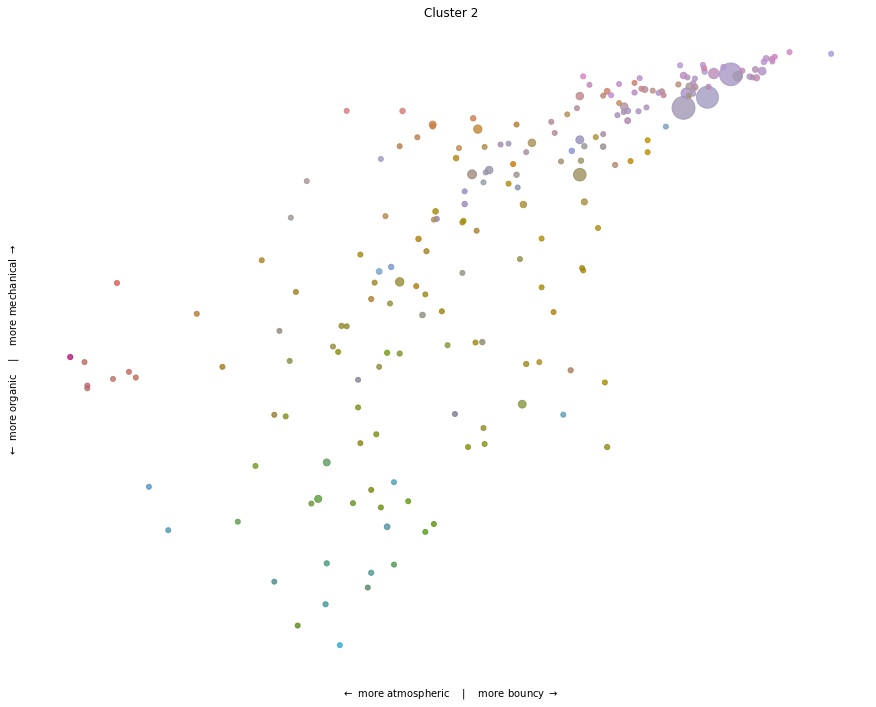

In [33]:
plot_cluster_footprint(2)

In [31]:
# add slider interaction
@widgets.interact(cluster_id=(0,genre_clusters['size'],1))
def plot_cluster_footprint_interactive(cluster_id):
    return plot_cluster_footprint(cluster_id)

interactive(children=(IntSlider(value=4, description='cluster_id', max=8), Output()), _dom_classes=('widget-in…

## Save the results

In [24]:
# # Save all the data
# tracks_df.to_pickle('../Data/pkl/03_spotify_data_clustered.pkl')
# tracks_df.to_csv('../Data/csv/03_spotify_data_clustered.csv')  # For visualization